In [1]:
%%capture --no-stderr
%pip install -U --quiet langgraph langsmith langchain_openai langchainhub langchain_core langchain_community langchain 
%pip install --upgrade --quiet  playwright > /dev/null
!playwright install

In [1]:
# Optional: add tracing to visualize the agent trajectories
import os
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"
_getpass("LANGCHAIN_API_KEY")
_getpass("OPENAI_API_KEY")

In [2]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

In [44]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

In [45]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


# async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"

async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Scrolling the entire window
        scroll_amount = 500
        scroll_direction = -scroll_amount if direction.lower() == "up" else scroll_amount
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
        return f"Scrolled {direction} in window"
    else:
        # Scrolling within a specific element
        try:
            target_id = int(target)
            if target_id < 0 or target_id >= len(state["bboxes"]):
                return f"Error: Invalid bounding box ID {target_id}. Valid range is 0 to {len(state['bboxes']) - 1}."
            
            bbox = state["bboxes"][target_id]
            x, y = bbox["x"], bbox["y"]
            scroll_amount = 200
            scroll_direction = -scroll_amount if direction.lower() == "up" else scroll_amount
            await page.mouse.move(x, y)
            await page.mouse.wheel(0, scroll_direction)
            return f"Scrolled {direction} in element {target_id}"
        except ValueError:
            return f"Error: Invalid target '{target}'. Expected 'WINDOW' or a number."

async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."


async def open_new_tab(state: AgentState):
    browser = state["page"].context.browser
    new_page = await browser.new_page()
    state["page"] = new_page
    return "Opened a new tab."


async def switch_to_previous_tab(state: AgentState):
    context = state["page"].context
    pages = context.pages
    current_index = pages.index(state["page"])
    if current_index > 0:
        state["page"] = pages[current_index - 1]
        return f"Switched to the previous tab (index: {current_index - 1})."
    else:
        return "Already on the first tab. No previous tab to switch to."

In [46]:
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


# @chain_decorator
# async def mark_page(page):
#     await page.evaluate(mark_page_script)
#     for _ in range(10):
#         try:
#             bboxes = await page.evaluate("markPage()")
#             break
#         except Exception:
#             # May be loading...
#             asyncio.sleep(3)
#     screenshot = await page.screenshot()
#     # Ensure the bboxes don't follow us around
#     await page.evaluate("unmarkPage()")
#     return {
#         "img": base64.b64encode(screenshot).decode(),
#         "bboxes": bboxes,
#     }

@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    bboxes = None
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            await asyncio.sleep(3)
    
    if bboxes is None:
        raise Exception("Failed to get bounding boxes after multiple attempts")
    
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

In [47]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    thought_prefix = "Thought: "
    action_prefix = "Action: "
    reply_prefix = "Reply: "
    
    lines = text.strip().split("\n")
    thought = ""
    action = ""
    reply = ""
    
    for line in lines:
        if line.startswith(thought_prefix):
            thought = line[len(thought_prefix):].strip()
        elif line.startswith(action_prefix):
            action = line[len(action_prefix):].strip()
        elif line.startswith(reply_prefix):
            reply = line[len(reply_prefix):].strip()
    
    if not action:
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    
    split_output = action.split(" ", 1)
    if len(split_output) == 1:
        action_type, action_input = split_output[0], None
    else:
        action_type, action_input = split_output
    
    action_type = action_type.strip()
    if action_input is not None:
        action_input = [inp.strip().strip("[]") for inp in action_input.strip().split(";")]
    
    return {
        # "thought": thought,
        "action": action_type,
        "args": action_input,
        "reply": reply
    }


In [43]:
# # Will need a later version of langchain to pull
# # this image prompt template
# prompt = hub.pull("nischal/supademo")
# prompt.partial_variables={'scratchpad': []}
# prompt.input_variables=['bbox_descriptions', 'img', 'input']

# prompt2 = hub.pull("wfh/web-voyager")
# from langchain.prompts import MessagesPlaceholder
# prompt3 = hub.pull("nischal/supademo2")
# prompt3 = prompt3.partial(scratchpad=MessagesPlaceholder(variable_name='scratchpad', optional=True))

In [48]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
    PromptTemplate,
)
from langchain_core.prompts.image import ImagePromptTemplate

from typing import List, Union
from langchain_core.messages import AIMessage, HumanMessage, ChatMessage, SystemMessage, FunctionMessage, ToolMessage

system_prompt = """You are a customer demo ai robot. You demo to the prospective customers how to use a web based SaaS platform. You have the capability to browse the web, just like a human. Now you need to show the customer how to perform an action on the platform. You also will have to speak to converse with the user as to what action you are taking. 

In each iteration, you will recieve an Observation that includes a screenshot of a webpage and some texts. 
This screenshot will feature Numerical Labels placed in the TOP LEFT corner of each Web Element. 
Carefully analyze the visual information to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow the guidelines and choose one of the following actions:

1. Click a Web Element.
2. Delete existing content in a textbox and then type content.
3. Scroll up or down.
4. Wait 
5. Go back
7. Return to google to start over.
8. Respond with the final answer

Correspondingly, Action should STRICTLY follow the format:

- Click [Numerical_Label] 
- Type [Numerical_Label]; [Content] 
- Scroll [Numerical_Label or WINDOW]; [up or down] 
- Wait 
- GoBack
- Google
- ANSWER; [content]

Key Guidelines You MUST follow:

* Action guidelines *
1) Execute only one action per iteration.
2) When clicking or typing, ensure to select the correct bounding box.
3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.

* Customer Interaction Guidelines*
1) You are performing the job of a real sales person. You should keep your tone friendly.
2) When you select an Action say Click - your customer interaction should be like - Now we will click this button so that we can move ahead in completing the task. Make it better and more naturally conversational.


* Web Browsing Guidelines *
1) Select strategically to minimize time wasted.

Your reply SHOULD STRICTLY follow the format:

Thought: {{Your brief thoughts (briefly summarize the info that will help ANSWER)}}
Action: {{One Action format you choose}}
Reply: {{You conversational reply to the customer}}
Then the User will provide:
Observation: {{A labeled screenshot Given by User}}
"""

system_message_prompt = SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template=system_prompt))

human_message_prompt = HumanMessagePromptTemplate(prompt=[
    ImagePromptTemplate(input_variables=['img'], template={'url': 'data:image/png;base64,{img}'}),
    PromptTemplate(input_variables=['bbox_descriptions'], template='{bbox_descriptions}'),
    PromptTemplate(input_variables=['input'], template='{input}')
])

prompt = ChatPromptTemplate(
    input_variables=['bbox_descriptions', 'img', 'input'],
    input_types={'scratchpad': List[Union[AIMessage, HumanMessage, ChatMessage, SystemMessage, FunctionMessage, ToolMessage]]},
    partial_variables={'scratchpad': []},
    messages=[
        system_message_prompt,
        MessagesPlaceholder(variable_name='scratchpad', optional=True),
        human_message_prompt
    ]
)

print(prompt)

input_variables=['bbox_descriptions', 'img', 'input'] input_types={'scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]} partial_variables={'scratchpad': []} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a customer demo ai robot. You demo to the prospective customers how to use a web based SaaS platform. You have the capability to browse the web, just like a human. Now you need to show the customer how to perform an action on the platform. You also will have to speak to converse with the user as to what action you are taking. \n\nIn each iteration, you will recieve an Observation that includes a screenshot of a webpage and some texts. \nThis screenshot will feature Numerical Labels placed i

In [50]:
llm = ChatOpenAI(model="gpt-4-turbo", max_tokens=4096)
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

In [51]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

In [52]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
    "OpenNewTab": open_new_tab,
    "SwitchToPreviousTab": switch_to_previous_tab
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

In [53]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://collectivai.atlassian.net/jira/software/projects/KAN/boards/1")


In [54]:
async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        # thought = pred.get("thought", "")
        action = pred.get("action")
        action_input = pred.get("args")
        reply = pred.get("reply", "")
        display.clear_output(wait=False)
        # steps.append(f"{len(steps) + 1}. Thought: {thought}")
        steps.append(f"   Action: {action}: {action_input}")
        steps.append(f"   Reply: {reply}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

   Action: Click: ['43']
   Reply: Now, we'll click on the "Create issue" button in the "To Do" section so we can add the new task titled "Talk to management". This will help us track and manage this task within the project.
   Action: Type: ['43', 'Talk to management']
   Reply: Let's go ahead and add the new task titled "Talk to management" into the 'To Do' section. I'll type this into the designated area now.
   Action: Click: ['46']
   Reply: Now, let's go ahead and click on the "Create" button within the "To Do" section to add the new issue titled "Talk to management". This will help us manage tasks efficiently in the project board.
   Action: Click: ['49']
   Reply: Now, let's add the issue to the board. I'll click on the 'Create issue' button to start the process.
   Action: Click: ['45']
   Reply: Let's go ahead and add a new task to the "To Do" list. I'll click on the 'Create issue' button to get started.
   Action: Click: ['49']
   Reply: Now we'll add a new issue by clicking

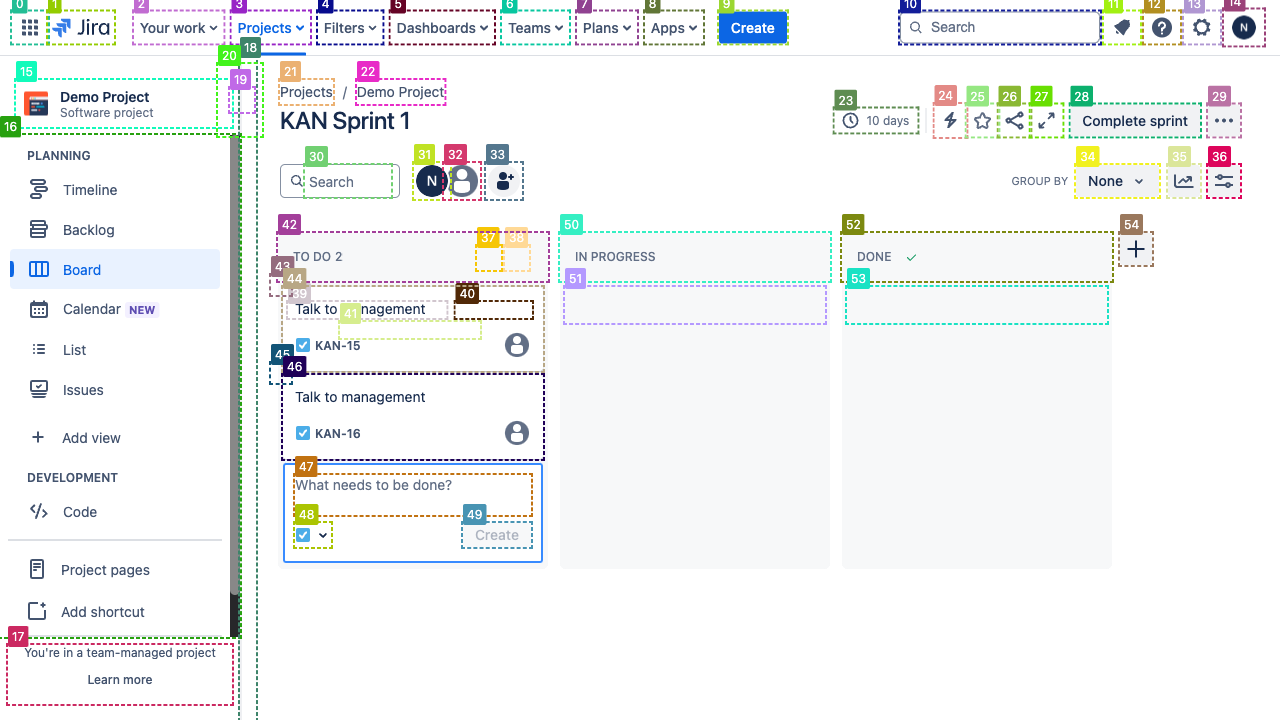

Exception ignored in: <function BaseEventLoop.__del__ at 0x106f8ca40>
Traceback (most recent call last):
  File "/Users/namanjain/Desktop/repos/supademo/.conda/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/Users/namanjain/Desktop/repos/supademo/.conda/lib/python3.11/asyncio/base_events.py", line 689, in is_closed
    return self._closed
           ^^^^^^^^^^^^
AttributeError: '_UnixSelectorEventLoop' object has no attribute '_closed'
Exception ignored in: <function BaseEventLoop.__del__ at 0x106f8ca40>
Traceback (most recent call last):
  File "/Users/namanjain/Desktop/repos/supademo/.conda/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/Users/namanjain/Desktop/repos/supademo/.conda/lib/python3.11/asyncio/base_events.py", line 689, in is_closed
    return self._closed
           ^^^^^^^^^^^^
AttributeError: '_UnixSelectorEventLo

CancelledError: 

In [59]:
# res = await call_agent("""
#                     You job is to add a contact with name John and email john@doe.com on hubspot. Your primary way to navigate the CRM should be from the side nav which is collapsed into icons.
#                     If any tutorial guide pops up that offers to help you in the task, refuse / decline it and do it on your own. 
#                     """, page)
# print(f"Final response: {res}")

res = await call_agent("""
                    Add a new issue in the todo list with the title : "Talk to management". 
                       ONLY add ONE issue. As soon as you see on issue with the title, stop executing. Use the create issue button in the todo list and not 
                    """, page)
print(f"Final response: {res}")

In [84]:
page.evaluate("unmarkPage()")

<coroutine object Page.evaluate at 0x10f986740>

In [111]:
import json

async def test_mark_page_script(page):
        
        # Read the mark_page.js script
        with open("mark_page2.js", "r") as f:
            mark_page_script = f.read()
        
        # Inject and execute the script
        await page.evaluate(mark_page_script)
        
        # Execute markPage() and get the results
        result = await page.evaluate("markPage()")
        
        # Print the results
        print(json.dumps(result, indent=2))
        
        # Keep the browser open for 10 seconds to visually inspect the bounding boxes
        await page.wait_for_timeout(10000)


# Example usage
await test_mark_page_script(page)

[
  [
    {
      "id": "element-0",
      "interactable": false,
      "tagName": "body",
      "attributes": {
        "class": "hubspot ui-app sticky-global-toolbar hubspot-disable-focus-styles",
        "unique_id": "FdAx",
        "style": "--global-nav-sticky-nav-before-container-top: 0px; --global-nav-sticky-growth-dynamic-container-top: 0px; --global-nav-notifications-banner-iframe-top: 0px; --global-nav-onboarding-tours-banner-top: 0px; --global-nav-sticky-nav-top: 0px;"
      },
      "text": "\u2318 K Upgrade       collectivai.com User Guides Marketing Guide Sales Guide Customer Service Guide Content Guide Commerce Guide View your plan Invite your team Start overview demo Your Sales tools progress 17% complete 17% Recommended: All you need to get started Set up the basics Import your contacts, invite teammates, and understand HubSpot properties 40% complete 40% About 8 minutes left Close more deals faster with Sales Hub Track your deals in one place Create a custom pipeline,

In [113]:
import json

async def test_mark_page_script(page):
        
        # Read the mark_page.js script
        with open("mark_page.js", "r") as f:
            mark_page_script = f.read()
        
        # Inject and execute the script
        await page.evaluate(mark_page_script)
        
        # Execute markPage() and get the results
        result = await page.evaluate("markPage()")
        
        # Print the results
        print(json.dumps(result, indent=2))
        
        # Keep the browser open for 10 seconds to visually inspect the bounding boxes
        await page.wait_for_timeout(10000)


# Example usage
await test_mark_page_script(page)

[
  {
    "x": 640,
    "y": 22,
    "type": "div",
    "text": "HubSpotSearch\u2318KUpgradeUpgradeCallingMarketplacesHelpSettingscollectivai.com",
    "ariaLabel": ""
  },
  {
    "x": 32,
    "y": 70,
    "type": "button",
    "text": "Bookmarks",
    "ariaLabel": ""
  },
  {
    "x": 32,
    "y": 147,
    "type": "button",
    "text": "Workspaces",
    "ariaLabel": ""
  },
  {
    "x": 32,
    "y": 199,
    "type": "button",
    "text": "CRM",
    "ariaLabel": ""
  },
  {
    "x": 32,
    "y": 251,
    "type": "button",
    "text": "Marketing",
    "ariaLabel": ""
  },
  {
    "x": 32,
    "y": 303,
    "type": "button",
    "text": "Content",
    "ariaLabel": ""
  },
  {
    "x": 32,
    "y": 355,
    "type": "button",
    "text": "Commerce",
    "ariaLabel": ""
  },
  {
    "x": 32,
    "y": 407,
    "type": "button",
    "text": "Automations",
    "ariaLabel": ""
  },
  {
    "x": 32,
    "y": 459,
    "type": "button",
    "text": "Reporting",
    "ariaLabel": ""
  },
  {
    "x

In [105]:
import json

async def test_mark_page_script(page):
    # Read the goodscript.js file
    with open("goodscript.js", "r") as f:
        good_script = f.read()
    
    # Inject and execute the script
    await page.evaluate(good_script)
    
    # Execute buildTreeFromBody() and get the results
    result = await page.evaluate("buildTreeFromBody()")
    
    # Print the results
    print(json.dumps(result[1], indent=2))  # Print the resultArray (index 1 of the returned tuple)
    
    # Instead of drawing bounding boxes, let's log some information about the elements
    elements = result[0]
    print(f"Total elements found: {len(elements)}")
    
    # Print information about the first 5 elements (if available)
    for i, element in enumerate(elements[:5]):
        print(f"Element {i + 1}:")
        print(f"  Tag: {element.get('tagName')}")
        print(f"  Interactable: {element.get('interactable')}")
        print(f"  Text: {element.get('text')[:50]}...")  # First 50 characters of text
    
    # Keep the browser open for 10 seconds to allow for manual inspection if needed
    # await page.wait_for_timeout(10000)

# Example usage
await test_mark_page_script(page)

[
  {
    "id": "FdAx",
    "frame": "main.frame",
    "interactable": true,
    "tagName": "body",
    "attributes": {
      "class": "hubspot ui-app sticky-global-toolbar hubspot-disable-focus-styles",
      "unique_id": "FdAx",
      "style": "--global-nav-sticky-nav-before-container-top: 0px; --global-nav-sticky-growth-dynamic-container-top: 0px; --global-nav-notifications-banner-iframe-top: 0px; --global-nav-onboarding-tours-banner-top: 0px; --global-nav-sticky-nav-top: 0px;"
    },
    "text": "",
    "children": [
      {
        "id": "ptYR",
        "frame": "main.frame",
        "interactable": true,
        "tagName": "div",
        "attributes": {
          "id": "hs-nav-v4",
          "class": "nav-width-flex placeholder-nav",
          "unique_id": "ptYR"
        },
        "text": "",
        "children": [
          {
            "id": "bMhK",
            "frame": "main.frame",
            "interactable": true,
            "tagName": "div",
            "attributes": {
  

In [110]:
import json

async def test_mark_page_script(page):
    # Read the goodscript.js file
    with open("goodscript.js", "r") as f:
        good_script = f.read()
    
    # Inject and execute the script
    await page.evaluate(good_script)
    
    # Execute buildTreeFromBody() and get the results
    result = await page.evaluate("buildTreeFromBody()")
    
    elements = result[0]
    print(f"Total elements found: {len(elements)}")
    
    # Filter for interactable elements
    interactable_elements = [elem for elem in elements if elem.get('interactable')]
    print(f"Interactable elements found: {len(interactable_elements)}")
    
    # Print information about the first 5 interactable elements
    for i, element in enumerate(interactable_elements[:5]):
        print(f"Interactable Element {i + 1}:")
        print(f"  Tag: {element.get('tagName')}")
        print(f"  Text: {element.get('text')[:50]}...")  # First 50 characters of text
        print(f"  Rect: {element.get('rect')}")
    
    # Draw bounding boxes for interactable elements
    await page.evaluate("""
        (elements) => {
            console.log('Drawing bounding boxes for', elements.length, 'elements');
            drawBoundingBoxes(elements);
            console.log('Bounding boxes drawn');
        }
    """, interactable_elements)
    
    # Check if bounding boxes were created
    bounding_box_count = await page.evaluate("""
        () => {
            const container = document.querySelector('#boundingBoxContainer');
            return container ? container.childElementCount : 0;
        }
    """)
    print(f"Number of bounding boxes created: {bounding_box_count}")
    
    # Keep the browser open for 10 seconds to allow for manual inspection
    await page.wait_for_timeout(10000)
    
    # Remove bounding boxes
    await page.evaluate("removeBoundingBoxes()")

# Example usage
await test_mark_page_script(page)

Total elements found: 313
Interactable elements found: 310
Interactable Element 1:
  Tag: body
  Text: ...
  Rect: {'bottom': 720, 'top': 0, 'left': 0, 'right': 1280, 'width': 1280, 'height': 720}
Interactable Element 2:
  Tag: div
  Text: ...
  Rect: {'bottom': 44, 'top': 0, 'left': 0, 'right': 1280, 'width': 1280, 'height': 44}
Interactable Element 3:
  Tag: div
  Text: ...
  Rect: {'bottom': 44, 'top': 0, 'left': 0, 'right': 1280, 'width': 1280, 'height': 44}
Interactable Element 4:
  Tag: header
  Text: ...
  Rect: {'bottom': 44, 'top': 0, 'left': 0, 'right': 1280, 'width': 1280, 'height': 44}
Interactable Element 5:
  Tag: div
  Text: ...
  Rect: {'bottom': 44, 'top': 0, 'left': 12, 'right': 64, 'width': 52, 'height': 44}
Number of bounding boxes created: 254
